<center>
<img src="../../img/ods_stickers.jpg">
## <center>Открытый курс по машинному обучению
<center> Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий



# <center>Домашнее задание 7. <br> Метод главных компонент, t-SNE и кластеризация</center>

В этой домашней работе мы  попрактикуемся в снижении размерности, визуализации и кластеризации данных, встроенных в `sklearn`. Ответы на вопросы заполните в [веб-форме](https://docs.google.com/forms/d/e/1FAIpQLSdjgje8qvptEW1EKY-QBbHXmXGIs6QYK2PqhchzF4Kpg3v8OQ/viewform?usp=sf_link).

## 1. PCA

Начнём с того, что импортируем все необходимые модули

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(style='white')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn import datasets
from sklearn.model_selection import train_test_split

Дана игрушечная выборка. 

In [17]:
X = np.array([[2., 13.], [1., 3.], [6., 19.],
              [7., 18.], [5., 17.], [4., 9.],
              [5., 22.], [6., 11.], [8., 25.]])

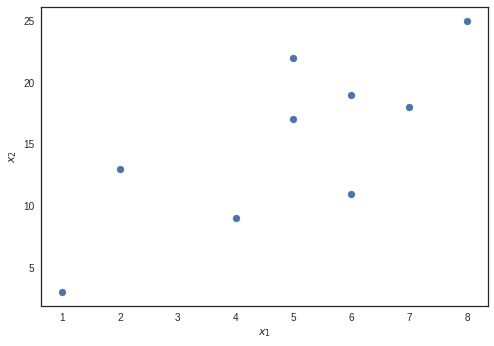

In [18]:
plt.scatter(X[:,0], X[:, 1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$');

<font color='red'>Вопрос 1. </font>На сколько градусов относительно оси $x_1$ повернут вектор, задающий 1 главную компоненту в этих данных (на забудьте отмасштабировать выборку при помощи StandardScaler)? 
- 30 градусов
- 45 градусов
- 60 градусов
- 75 градусов

In [19]:
X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[-1.35534369, -0.3430981 ],
       [-1.82450112, -1.88703953],
       [ 0.52128604,  0.58326676],
       [ 0.99044347,  0.42887262],
       [ 0.0521286 ,  0.27447848],
       [-0.41702883, -0.96067467],
       [ 0.0521286 ,  1.04644919],
       [ 0.52128604, -0.65188638],
       [ 1.4596009 ,  1.50963162]])

In [21]:
def alpha_betta(tensor):
    a = sum(pow(tensor[:,0], 2))
    c = sum(pow(tensor[:,1], 2))
    b = sum(tensor[:,0]*tensor[:,1])
    print(a, b, c)
    return b
alpha_betta(X_scaled)

9.0 6.96987203843 9.0


6.9698720384275816

In [15]:
X_test = np.array([[1., 3.],
              [3., 5.],
              [5., 1.],
              [7., 4.],
              [4., 7.]])
X_test_scaled = StandardScaler().fit_transform(X)
alpha_betta(X_scaled)

5.0 -0.25 5.0


0

<font color='red'>Вопрос 2. </font> Каковы собственные значения матрицы $X^TX$, где $X$ – матрица, соответствующая отмасштабированной выборке? 

 - 4 и 1.42
 - 16.2 и 2702.8
 - 4.02 и 51.99
 - 15.97 и 2.03

In [23]:
X_scaled.T.dot(X_scaled)

array([[ 9.        ,  6.96987204],
       [ 6.96987204,  9.        ]])

In [24]:
np.linalg.eig(X_scaled.T.dot(X_scaled))[1]

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [25]:
np.linalg.eig(X_scaled.T.dot(X_scaled))[0]

array([ 15.96987204,   2.03012796])

<font color='red'>Вопрос 3. </font> В чем смысл двух чисел из прошлого вопроса? 

- их квадраты говорят о том, какую часть дисперсии исходных данных объясняют главные компоненты
- они задают угол, на который 1-я главная компонента повернута относительно исходных координат
- эти числа говорят о том, какую часть дисперсии исходных данных объясняют главные компоненты
- корни из этих чисел задают угол, на который 1-я главная компонента повернута относительно исходных координат

Загрузим датасет с лицами людей и выведем имена этих людей (это должно делаться при подключении к Интернету, причем нужно неплохое соединение, не как в метро).

In [27]:
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=50, 
                resize=0.4, data_home='../../data/faces')

print('%d objects, %d features, %d classes' % (lfw_people.data.shape[0],
      lfw_people.data.shape[1], len(lfw_people.target_names)))
print('\nPersons:')
for name in lfw_people.target_names:
    print(name)

1560 objects, 1850 features, 12 classes

Persons:
Ariel Sharon
Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Hugo Chavez
Jacques Chirac
Jean Chretien
John Ashcroft
Junichiro Koizumi
Serena Williams
Tony Blair


Посмотрим на содержимое датасета. Все изображения лежат в массиве lfw_people.images

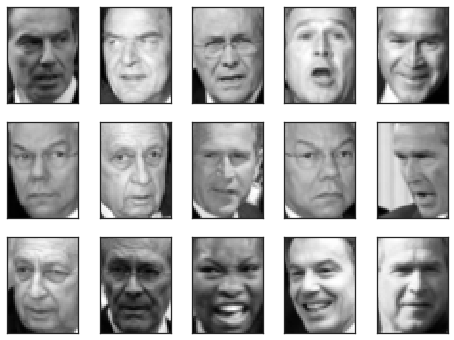

In [28]:
fig = plt.figure(figsize=(8, 6))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap='gray')





<font color='red'>Вопрос 4. </font>Какое **минимальное** число компонент PCA необходимо, чтобы объяснить 90% дисперсии масштабированных (при помощи StandardScaler) данных?

- 75
- 76
- 77
- 78

Для PCA в данной задаче стоит использовать параметр [`svd_solver='randomized'`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), который является приближением PCA, но позволяет существенно ускорить его работу на больших наборах данных. Для того, чтобы результаты можно было сравнивать, нужно зафиксировать `random_state=1`.

In [38]:
X = StandardScaler().fit_transform(lfw_people.data)
for n in range(1, 100):
    pca = PCA(n_components=n, svd_solver='randomized', random_state=1).fit(X)
    print(n, sum(pca.explained_variance_ratio_))
    if sum(pca.explained_variance_ratio_)>0.9:
        print(n, sum(pca.explained_variance_ratio_))
        break

1 0.268247478395
2 0.410106733419
3 0.481652552189
4 0.533291467506
5 0.56500614906
6 0.590435721918
7 0.610474328076
8 0.627224503526
9 0.643064253638
10 0.658283188011
11 0.671106435606
12 0.683669185565
13 0.695798133332
14 0.70608855549
15 0.715942983959
16 0.725213245621
17 0.734209889966
18 0.741994609106
19 0.748702350393
20 0.755206564688
21 0.76132647354
22 0.766947630769
23 0.772314612371
24 0.777564010482
25 0.782461721941
26 0.787069577012
27 0.791353172123
28 0.795511700619
29 0.799579648137
30 0.80333591228
31 0.806995978771
32 0.810558128271
33 0.813978153662
34 0.817363955877
35 0.820559718982
36 0.823642009958
37 0.826648797499
38 0.829483836144
39 0.832323586626
40 0.835056561721
41 0.837627207371
42 0.840248052227
43 0.842732982406
44 0.845186907982
45 0.847559135019
46 0.849855507666
47 0.852094898251
48 0.854300534661
49 0.856487123319
50 0.858570822593
51 0.860623652357
52 0.862611980846
53 0.864530791696
54 0.866431205206
55 0.868152756298
56 0.870056602281
57 0.

Постройте картинку, на которой изображены первые 30 главных компонент (только не пугайтесь, когда увидите, что получилось). Для этого надо эти 30 векторов взять из `pca.components_`, трансформировать опять по размеру исходных изображений (50 x 37) и нарисовать.

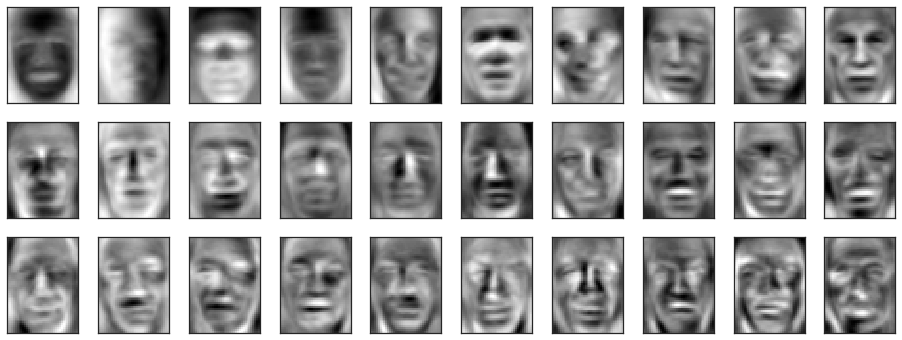

In [47]:
vect = pca.components_[:30]
plt.figure(figsize=(16, 6))
#for i in range(30):
#    plt.subplot(3, 10, i + 1)
#    plt.imshow(vect[i,:].reshape([50,37]));
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(vect[i].reshape([50,37]), cmap='gray')

<font color='red'>Вопрос 5. </font> Какая из первых 30 главных компонент сильнее всего "отвечает" за освещенность лица слева? Конкретней: для какой главной компоненты линейная комбинация исходных признаков (интенсивностей пикселов), если ее представить как изображение, выглядит, как фотография, ярко освещенная слева.

- 1
- 2
- 4
- 5

Теперь давайте построим проекцию лиц в пространство главных компонент с числом компонент равным 2.

<font color='red'>Вопрос 6. </font> Кто меньше всего похож на других людей в выборке, если выделять 2 главные компоненты? Для ответа на этот вопрос выделите 2 главные компоненты в масштабированных данных (используйте опять  параметр `svd_solver='randomized'` и `random_state=1`), посчитайте для каждого человека в выборке среднее значение 2 главных компонент всех его фотографий, затем из 12 2-мерных точек найдите наиболее удаленную от остальных (по среднему евклидову расстоянию до других точек). Можно это делать точно, а можно и на глаз с помощью `sklearn.metrics.euclidean_distances` и `seaborn.heatmap`.

- Колин Пауэлл
- Джордж Буш
- Жак Ширак
- Серена Уильямс

'Serena Williams'

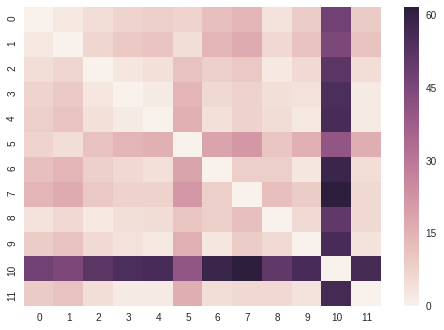

In [96]:
from sklearn.metrics.pairwise import euclidean_distances
X = StandardScaler().fit_transform(lfw_people.data)
X_pca = PCA(n_components=2, svd_solver='randomized', random_state=1).fit_transform(X)
data = pd.DataFrame(X_pca)
data['people'] = lfw_people.target
human_data = data.groupby('people').mean().values
dist = euclidean_distances(human_data, human_data)
sns.heatmap(dist)
lfw_people.target_names[10]

## 2. t-SNE

Возьмём упомянутый в статье способ визуализации данных с помощью [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) и посмотрим на наши лица на плоскости. При использовании `n_components=2` и `random_state=1` в левом верхнем углу проекции образуется кластер из лиц, относящихся к одному человеку. 

<font color='red'>Вопрос 7. </font> Какому человеку из набора данных lfw_people соответствуют два выброса в правом верхнем углу проекции t-SNE с параметрами `n_components=2` и `random_state=1`?

- Серена Уильямс
- Уго Чавес
- Джордж Буш
- Жак Ширак

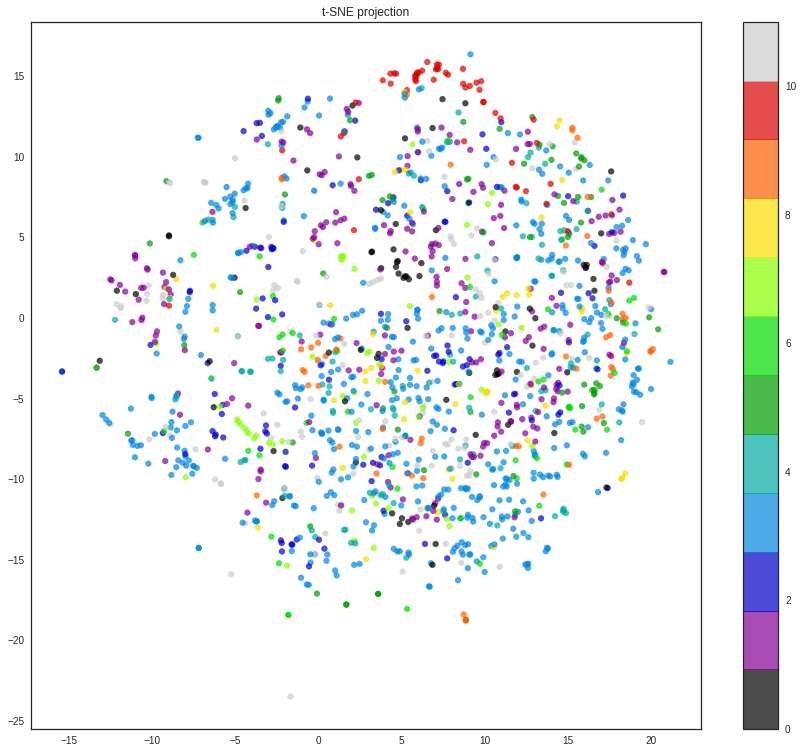

In [121]:
X = StandardScaler().fit_transform(lfw_people.data)
tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(15,13))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=lfw_people.target, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 12))
plt.colorbar()
plt.title('t-SNE projection');

## 3. Кластеризация

Для следующего вопроса загрузим набор данных с ценами на жильё:

In [108]:
boston = datasets.load_boston()
X = boston.data

Найдем с помощью метода локтя (см. 7 [статью](https://habrahabr.ru/company/ods/blog/325654/) курса) оптимальное число кластеров, которое стоит задать алгоритму kMeans в качестве гиперпараметра. 

<font color='red'>Вопрос 8. </font> Каким будет оптимальное число кластеров для датасета с ценами на жильё, если оценивать его с помощью метода локтя? Используйте в kMeans `random_state=1`, данные не масштабируйте.

- 2
- 3
- 4
- 5

В данном случае мы ищем наиболее выделеный излом в кривой расстояний до цетроидов в зависимости от числа кластеров. Будем рассматривать возможное число кластеров от 2 до 10. Как и в предыдущей задаче, нужно будет использовать `random_state=1` для инициализации алгоритма k-means.

4


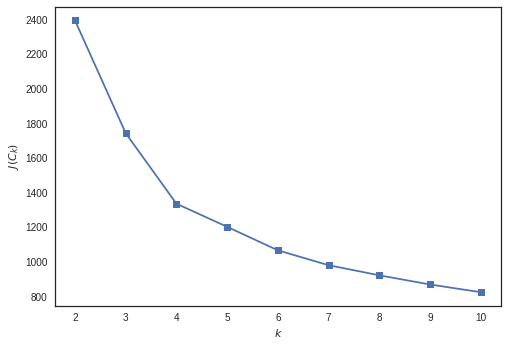

In [111]:
inertia = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(2, 11), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
print(4)
    

Вернемся к набору данных с лицами. Притворимся, что мы не знаем ответов – на какой фотографии кто изображен, но знаем, что это 12 разных людей. Давайте сравним результаты кластеризации фотографий с помощью 4 алгоритмов – KMeans, агломеративной кластеризации, AffinityPropagation и спектральной кластеризации. Параметры алгоритмов возьмите как в примере в конце [статьи](https://habrahabr.ru/company/ods/blog/325654/), только измените число кластеров на 12.

In [116]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

#X = lfw_people.data
X = StandardScaler().fit_transform(lfw_people.data)
algorithms = []
algorithms.append(KMeans(n_clusters=12, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=12, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=12))
data = []
for algo in algorithms:
    algo.fit(X)
    data.append(({
        'ARI': metrics.adjusted_rand_score(lfw_people.target, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(lfw_people.target, algo.labels_),
        'Homogenity': metrics.homogeneity_score(lfw_people.target, algo.labels_),
        'Completeness': metrics.completeness_score(lfw_people.target, algo.labels_),
        'V-measure': metrics.v_measure_score(lfw_people.target, algo.labels_),
        'Silhouette': metrics.silhouette_score(X, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means', 'Affinity', 
                              'Spectral', 'Agglomerative'])

results


,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,0.026403,0.062479,0.089133,0.078140,0.083275,0.047776
Affinity,0.014548,0.087505,0.306880,0.155006,0.205974,0.018944
Spectral,0.005589,0.068195,0.086609,0.095174,0.090690,-0.051164
Agglomerative,0.028770,0.067162,0.092784,0.083228,0.087747,0.024434


In [117]:
algorithms = []
algorithms.append(KMeans(n_clusters=2, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=2, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=2))
data = []
for algo in algorithms:
    algo.fit(X)
    data.append(({
        'ARI': metrics.adjusted_rand_score(lfw_people.target==10, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(lfw_people.target==10, algo.labels_),
        'Homogenity': metrics.homogeneity_score(lfw_people.target==10, algo.labels_),
        'Completeness': metrics.completeness_score(lfw_people.target==10, algo.labels_),
        'V-measure': metrics.v_measure_score(lfw_people.target==10, algo.labels_),
        'Silhouette': metrics.silhouette_score(X, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means', 'Affinity', 
                              'Spectral', 'Agglomerative'])

results


,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,0.029709,0.043241,0.203392,0.043697,0.071938,0.146082
Affinity,0.001449,0.017257,0.675572,0.023405,0.045243,0.018944
Spectral,0.166681,0.083546,0.290630,0.084138,0.130497,0.145372
Agglomerative,0.180638,0.096519,0.332501,0.097108,0.150316,0.162540


<font color='red'>Вопрос 9. </font> Выберите все верные утверждения:

- Агломеративная кластеризация справилась лучше всех других алгоритмов по всем метрикам качества
- Результаты кластеризации неудовлетворительные, ни одна из метрики не превышает 35%
- Affinity Propagation сработала лучше спектральной кластеризации по всем метрикам качества
- Если выделять только 2 кластера, а результаты кластеризации сравнивать с бинарным вектором, Серена Уильямс это или нет, то в целом алгоритмы справляются лучше, некоторые метрики превышают значение в 66%

Возьмите полученные раннее координаты 12 "средних" изображений людей. Постройте для них дендрограмму. Используйте  `scipy.cluster.hierarchy` и `scipy.spatial.distance.pdist`, параметры возьмите такие же, как в соответствующем примере в [статье](https://habrahabr.ru/company/ods/blog/325654/).

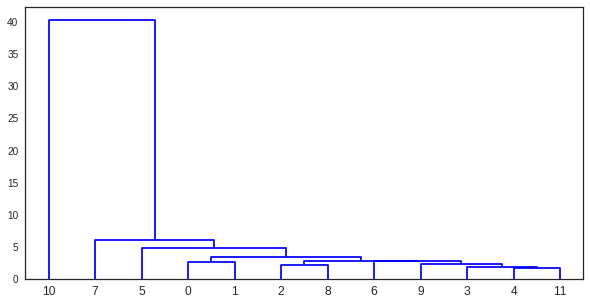

In [118]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

X = human_data

distance_mat = pdist(X) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'single') # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

<font color='red'>Вопрос 10. </font> Какому человеку соответствует точка, объединившаяся с другими при построении дендрограммы **предпоследней**?

- Gerhard Schroeder
- Jean Chretien
- John Ashcroft
- Junichiro Koizumi